## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2018-11-05 03:02:28--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  58.8MB/s    in 5.6s    

2018-11-05 03:02:34 (58.0 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout2d(p=0.05)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout2d(p=0.1)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout2d(p=0.15000000000000002)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout2d(p=0.2)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True,

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [8]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # added by Brandon
    net.eval()
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Check the Mean and Variance of Prediction

In [11]:
import pandas as pd
print(type(gt_pts.max()))
print('test image:   max:{},\t min:{}'.format(test_images.max(), test_images.min()))
print('test_outputs: max:{:.2f},\t min{:.2f}'.format(test_outputs.max().double(), 
                                                     test_outputs.min().double()))
print('gt_pts:       max:{:.2f},\t min{:.2f}'.format(gt_pts.max().double(),
                                                     gt_pts.min().double()))

df_y = pd.DataFrame(test_outputs.data.numpy().reshape(-1, 136))
df_y.describe()

<class 'torch.Tensor'>
test image:   max:0.9960784316062927,	 min:0.0
test_outputs: max:0.39,	 min-0.51
gt_pts:       max:2.19,	 min-1.33


,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.039098,0.085269,-0.092076,-0.031893,0.056768,0.123430,-0.048041,-0.073567,0.023313,-0.090371,...,-0.119780,-0.044641,-0.133173,0.004615,-0.158902,-0.018221,-0.046640,0.002406,0.065592,0.236135
std,0.043467,0.032781,0.038881,0.033194,0.041798,0.047805,0.031221,0.028060,0.032175,0.029959,...,0.038530,0.044934,0.041924,0.028299,0.072074,0.024000,0.038761,0.033609,0.037202,0.058014
min,-0.091954,0.039090,-0.154928,-0.110669,-0.009945,0.051415,-0.104240,-0.129405,-0.062869,-0.132688,...,-0.208981,-0.124917,-0.211770,-0.040901,-0.283711,-0.065656,-0.123624,-0.062769,-0.006917,0.142640
25%,0.027672,0.071328,-0.116728,-0.051104,0.023906,0.085119,-0.071387,-0.082448,0.008531,-0.118035,...,-0.149077,-0.074633,-0.162573,-0.011797,-0.207068,-0.027886,-0.068834,-0.012285,0.045148,0.196320
50%,0.041217,0.082082,-0.093971,-0.023198,0.055460,0.119311,-0.043690,-0.076434,0.026779,-0.092062,...,-0.117198,-0.040321,-0.121356,0.001910,-0.137664,-0.013208,-0.045901,0.005917,0.055460,0.236510
75%,0.060246,0.094354,-0.067986,-0.011484,0.091818,0.150317,-0.030634,-0.065686,0.035997,-0.064575,...,-0.091904,-0.005840,-0.106509,0.025814,-0.114635,-0.001458,-0.033367,0.019734,0.091446,0.274356
max,0.101177,0.184756,-0.022971,0.009456,0.121551,0.214204,0.002140,-0.022413,0.087808,-0.044869,...,-0.062397,0.016685,-0.056337,0.060380,-0.046634,0.017849,0.034630,0.065379,0.126976,0.348068


## Check Mean and Variance of Labels

In [12]:
df_label = pd.DataFrame(gt_pts.numpy().reshape(-1, 136))
df_label.describe()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,-0.805896,-0.064763,-0.785898,0.215173,-0.736712,0.461287,-0.681184,0.706917,-0.584597,0.969427,...,0.499706,0.861828,0.703052,0.891742,0.495084,0.924760,0.395144,0.946244,0.285444,0.928936
std,0.400362,0.387186,0.395675,0.366755,0.395625,0.340813,0.402464,0.321686,0.389114,0.318983,...,0.377377,0.345510,0.336928,0.322327,0.377950,0.334166,0.378186,0.341028,0.369752,0.349599
min,-1.332045,-0.608889,-1.332045,-0.331111,-1.332045,-0.053333,-1.332045,0.205926,-1.275227,0.409630,...,0.078190,0.275349,0.258864,0.428148,0.078190,0.470116,-0.044564,0.502222,-0.145235,0.428148
25%,-1.021559,-0.382981,-1.011619,-0.060016,-0.966688,0.214338,-0.946146,0.479891,-0.837064,0.750611,...,0.264012,0.692358,0.481965,0.721635,0.264012,0.729703,0.112826,0.749738,0.001702,0.692358
50%,-0.870718,-0.136196,-0.853939,0.118261,-0.795548,0.355121,-0.728878,0.596579,-0.614045,0.877229,...,0.435577,0.801751,0.694184,0.810110,0.424176,0.836473,0.371609,0.865574,0.227074,0.853835
75%,-0.617950,0.281917,-0.615563,0.496955,-0.537911,0.709917,-0.521677,0.915667,-0.444024,1.133792,...,0.615804,1.122337,0.807235,1.147433,0.615804,1.235096,0.540204,1.285288,0.400472,1.285288
max,0.172759,0.555862,0.172759,0.823448,0.172759,1.057586,0.254224,1.291724,0.308534,1.592759,...,1.394741,1.492414,1.503362,1.492414,1.394741,1.559310,1.286121,1.626207,1.177500,1.592759


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [13]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

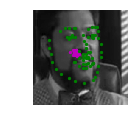

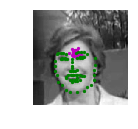

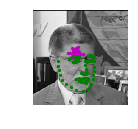

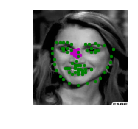

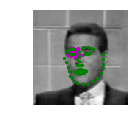

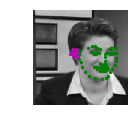

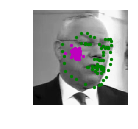

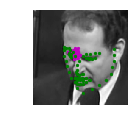

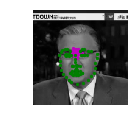

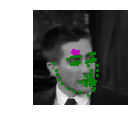

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [15]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.modules.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=1e-3)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [16]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [17]:
from datetime import datetime
# train your network
n_epochs = 1 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
start = datetime.now()

with active_session():
    train_net(n_epochs)
    
end = datetime.now()
elapsed_time = end - start
print('Elapse Time:{}\nAverage Time:{}'.format(elapsed_time, elapsed_time/ n_epochs))

Epoch: 1, Batch: 10, Avg. Loss: 0.48378199338912964
Epoch: 1, Batch: 20, Avg. Loss: 0.3428068608045578
Epoch: 1, Batch: 30, Avg. Loss: 0.25736345499753954
Epoch: 1, Batch: 40, Avg. Loss: 0.16769759282469748
Epoch: 1, Batch: 50, Avg. Loss: 0.13598423302173615
Epoch: 1, Batch: 60, Avg. Loss: 0.12213322296738624
Epoch: 1, Batch: 70, Avg. Loss: 0.13168728575110436
Epoch: 1, Batch: 80, Avg. Loss: 0.11967306360602378
Epoch: 1, Batch: 90, Avg. Loss: 0.12560702562332154
Epoch: 1, Batch: 100, Avg. Loss: 0.12023080587387085
Epoch: 1, Batch: 110, Avg. Loss: 0.11554894894361496
Epoch: 1, Batch: 120, Avg. Loss: 0.10434478670358657
Epoch: 1, Batch: 130, Avg. Loss: 0.13047153502702713
Epoch: 1, Batch: 140, Avg. Loss: 0.11965757831931115
Epoch: 1, Batch: 150, Avg. Loss: 0.09504542872309685
Epoch: 1, Batch: 160, Avg. Loss: 0.10319760963320732
Epoch: 1, Batch: 170, Avg. Loss: 0.1100844457745552
Epoch: 1, Batch: 180, Avg. Loss: 0.10619622692465783
Epoch: 1, Batch: 190, Avg. Loss: 0.0962719239294529
Epoch

In [23]:
n_epochs = 35 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
start = datetime.now()

with active_session():
    train_net(n_epochs)
    
end = datetime.now()
elapsed_time = end - start
print('Elapse Time:{}\nAverage Time:{}'.format(elapsed_time, elapsed_time/ n_epochs))

Epoch: 1, Batch: 10, Avg. Loss: 0.10788760259747505
Epoch: 1, Batch: 20, Avg. Loss: 0.09079711660742759
Epoch: 1, Batch: 30, Avg. Loss: 0.08550738804042339
Epoch: 1, Batch: 40, Avg. Loss: 0.09164759293198585
Epoch: 1, Batch: 50, Avg. Loss: 0.08054642267525196
Epoch: 1, Batch: 60, Avg. Loss: 0.08762473315000534
Epoch: 1, Batch: 70, Avg. Loss: 0.08548917807638645
Epoch: 1, Batch: 80, Avg. Loss: 0.08136132806539535
Epoch: 1, Batch: 90, Avg. Loss: 0.0830936886370182
Epoch: 1, Batch: 100, Avg. Loss: 0.07045691013336182
Epoch: 1, Batch: 110, Avg. Loss: 0.08472828976809979
Epoch: 1, Batch: 120, Avg. Loss: 0.08138456083834171
Epoch: 1, Batch: 130, Avg. Loss: 0.09123829826712608
Epoch: 1, Batch: 140, Avg. Loss: 0.09025364704430103
Epoch: 1, Batch: 150, Avg. Loss: 0.08257869705557823
Epoch: 1, Batch: 160, Avg. Loss: 0.06589659117162228
Epoch: 1, Batch: 170, Avg. Loss: 0.07054033949971199
Epoch: 1, Batch: 180, Avg. Loss: 0.0801654789596796
Epoch: 1, Batch: 190, Avg. Loss: 0.08177133239805698
Epoc

Epoch: 8, Batch: 100, Avg. Loss: 0.029828186519443987
Epoch: 8, Batch: 110, Avg. Loss: 0.03229233231395483
Epoch: 8, Batch: 120, Avg. Loss: 0.026006122305989265
Epoch: 8, Batch: 130, Avg. Loss: 0.02731039859354496
Epoch: 8, Batch: 140, Avg. Loss: 0.03168871402740479
Epoch: 8, Batch: 150, Avg. Loss: 0.03309428934007883
Epoch: 8, Batch: 160, Avg. Loss: 0.03207305120304227
Epoch: 8, Batch: 170, Avg. Loss: 0.0505624420940876
Epoch: 8, Batch: 180, Avg. Loss: 0.0356697091832757
Epoch: 8, Batch: 190, Avg. Loss: 0.027494629845023155
Epoch: 8, Batch: 200, Avg. Loss: 0.03540781568735838
Epoch: 8, Batch: 210, Avg. Loss: 0.037544010858982804
Epoch: 9, Batch: 10, Avg. Loss: 0.02874362263828516
Epoch: 9, Batch: 20, Avg. Loss: 0.02844172455370426
Epoch: 9, Batch: 30, Avg. Loss: 0.027451075613498688
Epoch: 9, Batch: 40, Avg. Loss: 0.034262332040816544
Epoch: 9, Batch: 50, Avg. Loss: 0.0354597520083189
Epoch: 9, Batch: 60, Avg. Loss: 0.030680350214242934
Epoch: 9, Batch: 70, Avg. Loss: 0.02728531565517

Epoch: 15, Batch: 160, Avg. Loss: 0.01774972854182124
Epoch: 15, Batch: 170, Avg. Loss: 0.018495080526918173
Epoch: 15, Batch: 180, Avg. Loss: 0.020960566587746143
Epoch: 15, Batch: 190, Avg. Loss: 0.01748110642656684
Epoch: 15, Batch: 200, Avg. Loss: 0.02229379564523697
Epoch: 15, Batch: 210, Avg. Loss: 0.023790527507662772
Epoch: 16, Batch: 10, Avg. Loss: 0.02171214045956731
Epoch: 16, Batch: 20, Avg. Loss: 0.01945231296122074
Epoch: 16, Batch: 30, Avg. Loss: 0.029601437412202357
Epoch: 16, Batch: 40, Avg. Loss: 0.021314225252717735
Epoch: 16, Batch: 50, Avg. Loss: 0.02129567936062813
Epoch: 16, Batch: 60, Avg. Loss: 0.029546931199729443
Epoch: 16, Batch: 70, Avg. Loss: 0.021665259543806315
Epoch: 16, Batch: 80, Avg. Loss: 0.023025762196630238
Epoch: 16, Batch: 90, Avg. Loss: 0.01954769026488066
Epoch: 16, Batch: 100, Avg. Loss: 0.01939493613317609
Epoch: 16, Batch: 110, Avg. Loss: 0.02420126674696803
Epoch: 16, Batch: 120, Avg. Loss: 0.027638351637870075
Epoch: 16, Batch: 130, Avg. 

Epoch: 22, Batch: 210, Avg. Loss: 0.02297789165750146
Epoch: 23, Batch: 10, Avg. Loss: 0.013856399804353714
Epoch: 23, Batch: 20, Avg. Loss: 0.026177211292088033
Epoch: 23, Batch: 30, Avg. Loss: 0.03230997347272933
Epoch: 23, Batch: 40, Avg. Loss: 0.01642061658203602
Epoch: 23, Batch: 50, Avg. Loss: 0.021138287521898745
Epoch: 23, Batch: 60, Avg. Loss: 0.013317822385579348
Epoch: 23, Batch: 70, Avg. Loss: 0.025444392953068017
Epoch: 23, Batch: 80, Avg. Loss: 0.012782914331182837
Epoch: 23, Batch: 90, Avg. Loss: 0.020142551325261594
Epoch: 23, Batch: 100, Avg. Loss: 0.016225801222026347
Epoch: 23, Batch: 110, Avg. Loss: 0.018855019006878138
Epoch: 23, Batch: 120, Avg. Loss: 0.03169018039479852
Epoch: 23, Batch: 130, Avg. Loss: 0.018619504570961
Epoch: 23, Batch: 140, Avg. Loss: 0.020964458025991915
Epoch: 23, Batch: 150, Avg. Loss: 0.01711370376870036
Epoch: 23, Batch: 160, Avg. Loss: 0.013611732423305512
Epoch: 23, Batch: 170, Avg. Loss: 0.018525967746973036
Epoch: 23, Batch: 180, Avg.

Epoch: 30, Batch: 50, Avg. Loss: 0.01848824182525277
Epoch: 30, Batch: 60, Avg. Loss: 0.015210840664803982
Epoch: 30, Batch: 70, Avg. Loss: 0.019515836704522373
Epoch: 30, Batch: 80, Avg. Loss: 0.015368903707712888
Epoch: 30, Batch: 90, Avg. Loss: 0.015280630718916655
Epoch: 30, Batch: 100, Avg. Loss: 0.01788407014682889
Epoch: 30, Batch: 110, Avg. Loss: 0.01849962053820491
Epoch: 30, Batch: 120, Avg. Loss: 0.017903565429151058
Epoch: 30, Batch: 130, Avg. Loss: 0.028108302596956493
Epoch: 30, Batch: 140, Avg. Loss: 0.02110371384769678
Epoch: 30, Batch: 150, Avg. Loss: 0.012006555031985045
Epoch: 30, Batch: 160, Avg. Loss: 0.015642501041293146
Epoch: 30, Batch: 170, Avg. Loss: 0.040189077891409394
Epoch: 30, Batch: 180, Avg. Loss: 0.03733746837824583
Epoch: 30, Batch: 190, Avg. Loss: 0.024688674509525298
Epoch: 30, Batch: 200, Avg. Loss: 0.02404201766476035
Epoch: 30, Batch: 210, Avg. Loss: 0.020224137417972087
Epoch: 31, Batch: 10, Avg. Loss: 0.013750598672777415
Epoch: 31, Batch: 20, 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [24]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


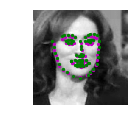

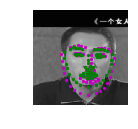

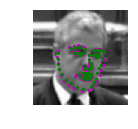

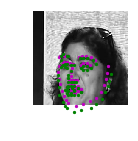

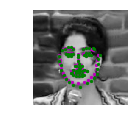

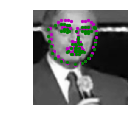

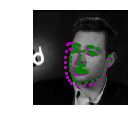

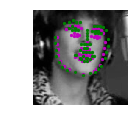

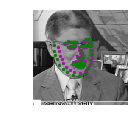

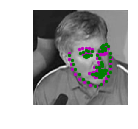

In [25]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [26]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_CNN_8_Loc.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

I use Adam optimizer because it runs faster at first few epochs. The training time is the key factor in this project because I found that GPU is only 50% faster than CPU. The GPU takes 15 min per epoch whereas CPU takes 23 mins per epoch. 
For loss function, I choose SmoothL1 which tightly fits to labels. Compared with MSE loss, SmoothL1 converges faster.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here
I firstly used 1 layer fully-connected network as the baseline for MSE loss. Then I switch to SmoothL1. I add batch normalization to speed training at first few epochs. At first time, I use 6 conv layers, but it converges too slowly. Then I reduce the number of conv to 4. And I also concate downsample input to the 2nd fully-connected layer. In short the architecture is 4 conv + 3 FC. To avoid overfitting, I add dropout layer at each layer. 


Aside from the above architectures, I also tried following architectures which are bad or hard to converge.
1. Transfer learning of DensNet121 
2. Using pretrained DensNet121
3. Concatenate downsampled input with conv2 or conv3. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

I choose batch_size as 16 because I want to see the result more quickly compared batch_size 32. For choosing epochs, I firstly inspect the first 1~3 epochs. If it converges quickly, I would add 5 more epochs. The total number of epochs is less than 50.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.1401528  -0.10645753 -0.03755455  0.15943925  0.16568388]
 [-0.01584765 -0.01644006 -0.04615501  0.11088489  0.07597099]
 [-0.16825111 -0.05968555 -0.17208812 -0.02629202 -0.04149569]
 [-0.10993748 -0.15129733  0.0109537   0.05833415 -0.04738645]
 [-0.14656597  0.05847396 -0.13283099  0.00750389  0.14268944]]
(5, 5)


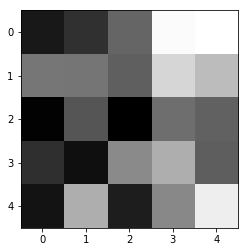

In [27]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

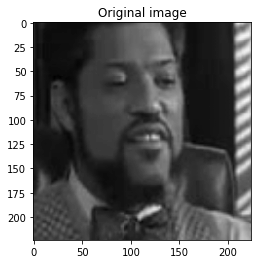

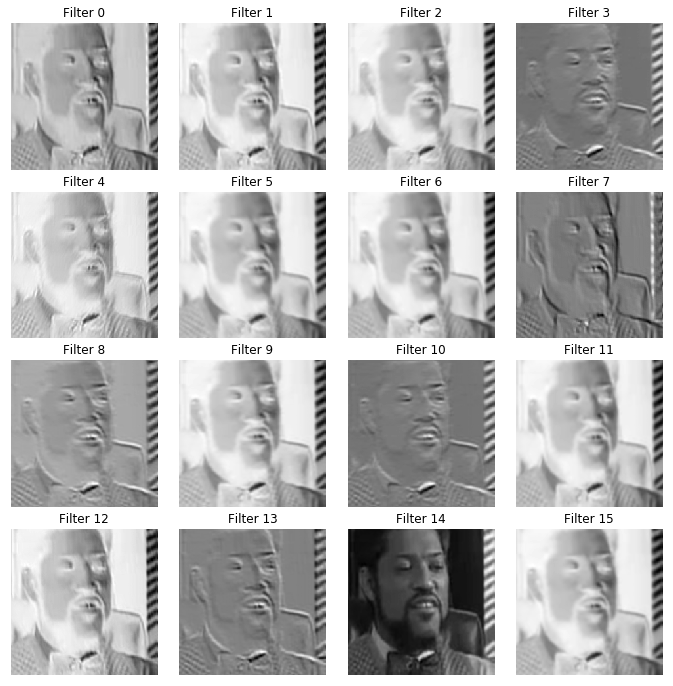

In [22]:
import cv2
import matplotlib.gridspec as gridspec

##TODO: load in and display any image from the transformed test dataset
image = test_images[0].data
image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
plt.imshow(image[..., 0], cmap="gray")
plt.title("Original image")

rows = 4
columns = 4
plt.figure(figsize = (12, 12))
gs1 = gridspec.GridSpec(rows, columns)
gs1.update(wspace=0.025, hspace=0.15) # set the spacing between axes. 

for i in range(columns * rows):
    f_img = cv2.filter2D(image, -1, w[i][0])
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(f_img, cmap="gray")
    ax1.set_title("Filter {}".format(i))
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

* Filter 14 is original image. 
* Filter 3 and 10 make image brighter. 
* Filter 7, 8, and 13 detects the edge.
* Others flip the grayscales. Among them, filter 5, 6, 11 and 15 blur the image. Filter 0 and 4 detect the edge.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!